# Measures of Potential Spatial Accessibility 

This notebook walks through measures of potential spatial accessibility. These measures assign accessibility scores to demand locations based on their proximity to supply locations.

## Background

A first natural measure is the distance to the nearest supply location. This captures important information about the accessibility of the supplied services. However, this technique may not always be applicable, as it assumes that the supply at each location is inexhaustable. When supply is scarce, people have to compete for access at each supply location. Accordingly, access should be discounted by the number of other people attempting to use the same limited supply.

The population-to-physician ratio accounts for this and is frequently used to define physician shortage areas, but the metric depends heavily on the choice of service area. It also doesn't account for geographic variation within each individual service area.

### Floating Catchment Area Methods

Floating catchment models attempt to address these problems by defining flexible service areas that vary across demand locations, with each demand location having access to only the providers within its associated service area. However, this still doesn't fully account for geographic accessibilty: if the catchment area has a radius of 30 miles, no distinction is made between demand points 10 miles and 20 miles away from a provider.

The two-step floating catchment area (2SFCA) method takes this one step further by accounting for demand. First, a supply-to-demand ratio is calculated for each supply location using a floating catchment area centered at the supply location to calculate the demand. Next, the accessibility score for each demand location is computed as the sum of these supply-to-demand ratios for all providers within a floating catchment area centered at the _demand_ location. 

The resulting scores can be thought of as the total supply-to-demand ratio being redistributed throughout the entire region. In fact, as we will see demonstrated, "the weighted mean of accessibility is equal to the ratio of total supply to total demand in the study area" (Wang, 2006). The output of the method can be thought of in the same way as the familiar population-to-physician ratio.


### Gravity Methods

In the 2SFCA method described above, a point is either inside a given catchment area or outside it and contributes its demand / supply accordingly. Gravity methods introduce a decay factor to account for decreased demand pressure as distance increases. Instead of treating the contribution of each person as 0 or 1, the contribution is multiplied by a decay factor that tends to 0 as the distance between the supply location and demand location increases. 

The typical decay function is $d^{-\beta}$ for some (positive) $\beta$ (with $\beta=2$ as the source of the methods' name). Using a decay function that's $1$ when $d < c$ for some cutoff $c$ and $0$ otherwise recovers the ordinary 2SFCA as a special case.

Similarly, modifying the decay function can accomodate what Luo and Qi call the enhanced two-step floating catchment area (E2SFCA) method, showing that all these seemingly separate methods belong to the same family. 

This notebook illustrates the use of the gravity method with non-standard decay functions. The standard decay function fails miserably in the current use case. This is because $d^{-\beta}$ approaches $\infty$ as $d$ approaches $0$, so demand locations very close to supply locations have extreme effects on the accessibility measure as a whole. This is not as problematic with a small number of points, since then the likelihood of overlap is less. Because we use so many (demand) locations, it is virtually guaranteed that each supply location has a demand location very close by.


### References and suggested reading
Luo, W. and Qi, Y. (2009) An enhanced two-step floating catchment area (E2SFCA) method for measuring spatial accessibility to primary care physicians. Health and Place 15, 1100–1107.

Luo, W. and Wang, F. (2003) Measures of spatial accessibility to health care in a GIS environment: synthesis and a case study in the Chicago region. Environment and Planning B: Planning and Design 30, 865–884.

Wang, F. (2006) Quantitative Methods and Applications in GIS. CRC Press/Taylor and Francis, Boca Raton, Florida. 

Wang, F. (2012) Measurement, optimization, and impact of health care accessibility: a methodological review. Annals of the Association of American Geographers 102, 1104–1112.

In [1]:
import collections
import functools
import itertools
import importlib
import json
import random
import requests
import multiprocessing

import geojson

import geopandas as gpd

import numpy as np

import pandas as pd

import shapely

from backend.config import config
from backend.lib.fetch import representative_points
from backend.lib.database.postgres import connect
from backend.lib.calculate import adequacy, gravity

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

try:
    import seaborn as sns
except ModuleNotFoundError:
    !pip install seaborn
    import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 12)
pd.set_option('max_columns', 999)
plt.style.use('seaborn-deep')

### Setup Variables

Let's quickly set up all the variables we'll need to perform our analysis.

Specifically, let's fetch the providers and representative points for a sample dataset, as well as a (pre-calculated) matrix of driving times between the representative points and the providers.

We'll use the "Abortion Clinics in Texas" dataset since it highlights a scenario with extreme lack of access.

In [2]:
# Define service areas and fetch representative points.
all_service_areas = requests.get('https://encompass.bayesimpact.org/api/available-service-areas/').json()
service_area_ids = [sa[0] for sa in all_service_areas if sa[3] == 'TX']
raw_points = representative_points.fetch_representative_points(
    service_area_ids=service_area_ids,
    include_census_data=False
)

In [3]:
# Define providers.
providers = json.loads(
    '''
[
        {
            "address": "1902 S IH-35 Suite A, Austin, TX 78704",
            "lat": 30.30886,
            "lng": -97.754883,
            "languages": [],
            "name": "Austin Women's Health Center",
            "specialty": "Abortion Clinic"
        },
        {
            "address": "201 East Ben White, Austin, TX 78704",
            "lat": 30.221356,
            "lng": -97.76293,
            "languages": [],
            "name": "Planned Parenthood, South Austin Health Center",
            "specialty": "Abortion Clinic"
        },
        {
            "address": "8401 N Interstate 35 Frontage Rd, Austin, TX 78753",
            "lat": 30.388532,
            "lng": -97.672564,
            "languages": [],
            "name": "Whole Woman's Health of Austin",
            "specialty": "Abortion Clinic"
        },
        {
            "address": "7989 W. Virginia Dr., Dallas, TX 75237",
            "lat": 32.649991,
            "lng": -96.877165,
            "languages": [],
            "name": "Planned Parenthood, South Dallas Surgical Health Services Center",
            "specialty": "Abortion Clinic"
        },
        {
            "address": "8616 Greenville Ave Ste 101, Dallas, TX 75243",
            "lat": 32.894425,
            "lng": -96.752722,
            "languages": [],
            "name": "Southwestern Women's Surgery Center",
            "specialty": "Abortion Clinic"
        },
        {
            "address": "6464 John Ryan Dr, Fort Worth, TX 76132",
            "lat": 32.654893,
            "lng": -97.420833,
            "languages": [],
            "name": "Planned Parenthood, Southwest Fort Worth Health Center",
            "specialty": "Abortion Clinic"
        },
        {
            "address": "3256 Lackland Road, Fort Worth, TX 76116",
            "lat": 32.725223,
            "lng": -97.435538,
            "languages": [],
            "name": "Whole Woman's Health of Fort Worth",
            "specialty": "Abortion Clinic"
        },
        {
            "address": "2505 N. Shepherd Dr., Houston, TX 77008",
            "lat": 29.809083,
            "lng": -95.410493,
            "languages": [],
            "name": "Texas Ambulatory Surgery Center, Aaron's Clinic",
            "specialty": "Abortion Clinic"
        },
        {
            "address": "4820 San Jacinto, Houston, TX 77004",
            "lat": 29.729907,
            "lng": -95.3843,
            "languages": [],
            "name": "Houston Women's Clinic",
            "specialty": "Abortion Clinic"
        },
        {
            "address": "4600 Gulf Freeway, Houston, TX 77023",
            "lat": 29.725695,
            "lng": -95.334709,
            "languages": [],
            "name": "Planned Parenthood, Center for Choice Ambulatory Surgical Center",
            "specialty": "Abortion Clinic"
        },
        {
            "address": "802 S. Main Street, McAllen, TX 78501",
            "lat": 26.196697,
            "lng": -98.235848,
            "languages": [],
            "name": "Whole Woman's Health of McAllen",
            "specialty": "Abortion Clinic"
        },
        {
            "address": "7402 John Smith Dr, #101, San Antonio, TX 78229",
            "lat": 29.506173,
            "lng": -98.586049,
            "languages": [],
            "name": "Alamo Women's Reproductive Services",
            "specialty": "Abortion Clinic"
        },
        {
            "address": "4025 East Southcross, San Antonio, TX 78222",
            "lat": 29.35494,
            "lng": -98.371889,
            "languages": [],
            "name": "Whole Woman's Health of San Antonio",
            "specialty": "Abortion Clinic"
        },
        {
            "address": "1511 E Missouri Avenue, El Paso, TX 79902",
            "lat": 31.770213,
            "lng": -106.476909,
            "languages": [],
            "name": "Reproductive Services Texas",
            "specialty": "Abortion Clinic"
        },
        {
            "address": "3101 Richmond Ave, Suite 250, Houston, TX 77098",
            "lat": 29.733334,
            "lng": -95.424668,
            "languages": [],
            "name": "Suburban Women's Clinic",
            "specialty": "Abortion Clinic"
        },
        {
            "address": "1121 Ross Avenue, Suite A, Waco, TX 76706",
            "lat": 31.546326,
            "lng": -97.131813,
            "languages": [],
            "name": "Audre Rapoport Abortion Services Center of Waco (Planned Parenthood)",
            "specialty": "Abortion Clinic"
        },
        {
            "address": "2140 Babcock Rd #201, San Antonio, TX 78229",
            "lat": 29.502565,
            "lng": -98.581715,
            "languages": [],
            "name": "Planned Parenthood, South Texas",
            "specialty": "Abortion Clinic"
        },
        {
            "address": "701 San Mateo NE, Albuquerque, NM 87108",
            "lat": 35.08388889,
            "lng": -106.58638889,
            "languages": [],
            "name": "Planned Parenthood, Surgical Center",
            "specialty": "Abortion Clinic"
        },
        {
            "address": "2301 Yale Blvd SE, Albuquerque, NM 87106",
            "lat": 35.055517,
            "lng": -106.622135,
            "languages": [],
            "name": "University of New Mexico Center for Reproductive Health",
            "specialty": "Abortion Clinic"
        },
        {
            "address": "522 Lomas Blvd. NE, Albuquerque, NM 87102",
            "lat": 35.089677,
            "lng": -106.639148,
            "languages": [],
            "name": "Southwestern Women's Options",
            "specialty": "Abortion Clinic"
        },
        {
            "address": "730 Saint Michaels Drive #4B, Santa Fe, NM 87505",
            "lat": 35.659339,
            "lng": -105.961294,
            "languages": [],
            "name": "Planned Parenthood, Santa Fe Health Center",
            "specialty": "Abortion Clinic"
        },
        {
            "address": "5107 East Kellogg Drive South, Wichita, KS 67218",
            "lat": 37.679112,
            "lng": -97.292205,
            "languages": [],
            "name": "South Wind Women's Center",
            "specialty": "Abortion Clinic"
        },
        {
            "address": "1240 S.W. 44th St., Oklahoma City, OK 73109",
            "lat": 35.420696,
            "lng": -97.538846,
            "languages": [],
            "name": "Trust Women South Wind Women's Center, Oklahoma City",
            "specialty": "Abortion Clinic"
        },
        {
            "address": "2453 Wilcox Drive, Norman, OK 73069",
            "lat": 35.206206,
            "lng": -97.478709,
            "languages": [],
            "name": "Abortion Surgery Center",
            "specialty": "Abortion Clinic"
        },
        {
            "address": "6136 E. 32nd Place, Tulsa, OK 74135",
            "lat": 36.116430,
            "lng": -95.906711,
            "languages": [],
            "name": "Reproductive Services",
            "specialty": "Abortion Clinic"
        },
        {
            "address": "210 Kings HWY, Shreveport, LA 71104",
            "lat": 32.481817,
            "lng": -93.734403,
            "languages": [],
            "name": "Hope Medical Group for Women",
            "specialty": "Abortion Clinic"
        },
        {
            "address": "1505 Doctors Drive, Bossier City, Louisiana 71111",
            "lat": 32.533081,
            "lng": -93.709751,
            "languages": [],
            "name": "Bossier City Medical Suite",
            "specialty": "Abortion Clinic"
        },
        {
            "address": "3044 Ridgelake Drive, Metarie, LA 70002",
            "lat": 30.006589,
            "lng": -90.153504,
            "languages": [],
            "name": "Causeway Medical Clinic",
            "specialty": "Abortion Clinic"
        },
        {
            "address": "2701 General Pershing St., New Orleans, LA",
            "lat": 29.937464,
            "lng": -90.101896,
            "languages": [],
            "name": "Women's Health Care Center",
            "specialty": "Abortion Clinic"
        },
        {
            "address": "1130 Alpine Ave., Boulder, CO 80304",
            "lat": 40.025486,
            "lng": -105.283232,
            "languages": [],
            "name": "Boulder Abortion Clinic",
            "specialty": "Abortion Clinic"
        }
    ]
'''
)

providers_tx_only = providers[:17]
locations = [
    {
        'id': idx,
        'latitude': provider['lat'],
        'longitude': provider['lng']
    } for idx, provider in enumerate(providers_tx_only)
]
try:
    driving_time_measurement_matrix = np.load('driving_time_measurement_matrix.npy')
except FileNotFoundError:
    driving_time_measurement_matrix = gravity.calculate_measurement_matrix(
       service_area_ids=service_area_ids,
       locations=locations,
       measurer_name='osrm',
    )

np.save('driving_time_measurement_matrix.npy', driving_time_measurement_matrix)

### Measuring Accessibility

Let's explore different ways we can measure accessibility, starting with the gravity method. 

All of the methods described in the introduction have free parameters: in the standard gravity model the decay exponent $\beta$ must be chosen; in 2SFCA the radius of the catchment areas must be chosen. Ideally, this parameter is intuitive and is specified in the same units as the measurements themselves to allow for a simplified selection process. The standard gravity model's $\beta$ fails this test spectacularly, another motivation for modifying the decay function.

We'll use a Gaussian decay function with one free parameter $\sigma$. This function has no decay at $0.0$ distance between a demand location and a supply location, but at the distance $2\sigma$ the demand is roughly 10% of the demand at the epicenter. The following visualizations use values of 80 miles (haversine) and three hours (driving time).

In [4]:
def calculate_gravities(
    service_area_ids,
    providers,
    decay_function,
    measurer_name='haversine',
    measurement_matrix=None
):
    locations = [
        {
            'id': idx,
            'latitude': provider['lat'],
            'longitude': provider['lng']
        } for idx, provider in enumerate(providers)
    ]
    if measurement_matrix is None:
        measurement_matrix = gravity.calculate_measurement_matrix(
            service_area_ids=service_area_ids,
            locations=locations,
            measurer_name=measurer_name,
        )

    gravities = gravity.calculate_accessibility_indexes(
        measurement_matrix=measurement_matrix,
        points=raw_points,
        decay_function=decay_function
    )
    for point, grav in zip(raw_points, gravities):
        point['gravity'] = grav
    df = pd.DataFrame.from_records(raw_points)
    
    df['closest_measurement'] = (-1)*np.min(measurement_matrix, axis=1)
    df['geometry'] = [
        shapely.geometry.Point(point) 
        for point in df[['lng', 'lat']].values
    ]
    gdf = gpd.GeoDataFrame(df)
    return gdf, measurement_matrix


def plot_access(gdf, column_name='gravity', log=False):
    gdf.plot(
        column=column_name,
        cmap='nipy_spectral',
        norm=colors.LogNorm(vmin=gdf[column_name].min(), vmax=gdf[column_name].max()) if log else None, 
        alpha=0.16,
        legend=True
    )

In [5]:
plt.rcParams['figure.figsize'] = (16, 12)

sigma = 80.*1609
decay_function=functools.partial(gravity.gaussian_decay, sigma=sigma)

gdf, mm = calculate_gravities(
    service_area_ids=service_area_ids,
    providers=providers_tx_only,
    decay_function=decay_function,
    measurement_matrix=None
)

First, let's visualize access in terms of distance to closest provider (measured in meters).

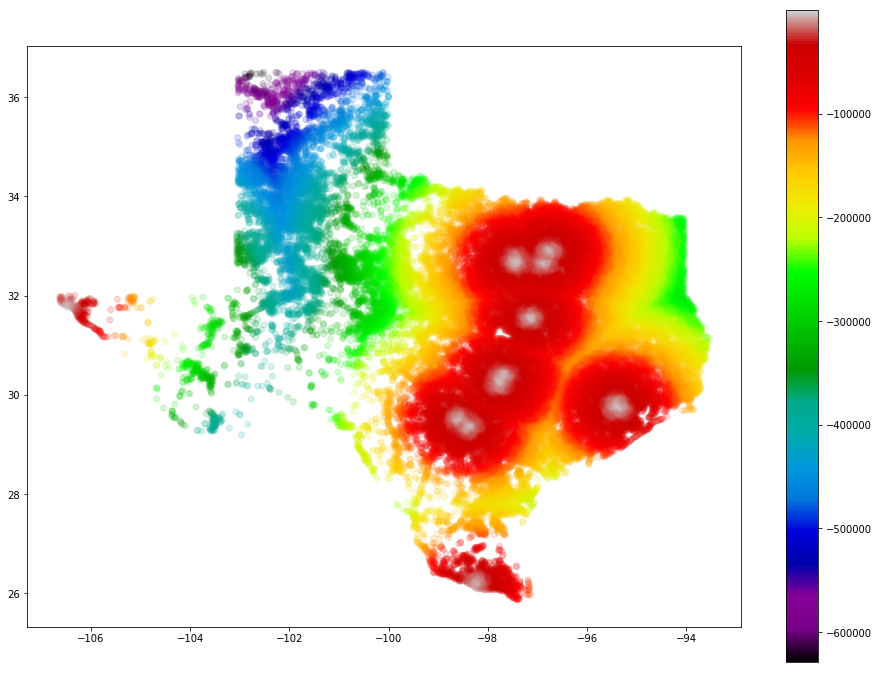

In [6]:
plot_access(gdf, column_name='closest_measurement', log=False)

As we can see, the providers are concentrated in Dallas, Houston, San Antonio, and Austin, with other providers in El Paso and McAllen. West Texas has the worst access by this metric: people need to travel over 400 km (250 miles) to the nearest provider.

Next, let's take a look at the accessibility as measured by a gravity based model operating under the assumption that a person who is 120 miles away from a provider contributes 10% of the demand that a person close to the provider does.

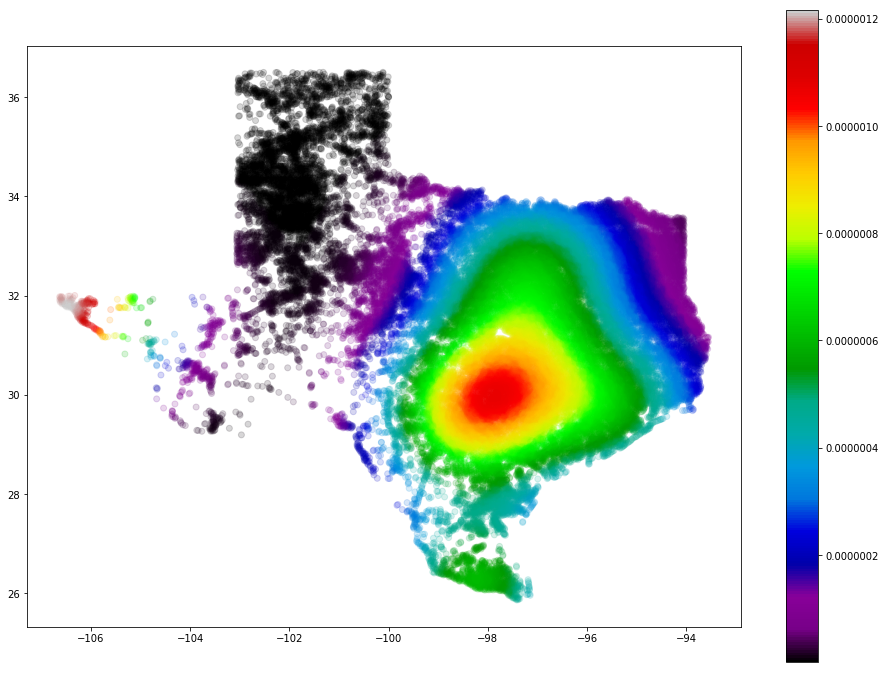

In [7]:
plot_access(gdf)

Some key differences between this map and the previous one: 

- Even though Houston and Dallas have multiple providers, their geographic access as measured by the gravity model is comparatively low (near the median). This is because the two metro areas have such a high population, resulting in high demands at these provider locations.
- Similarly, access in McAllen is less than expected, as one provider has to cover the entire southern tip of Texas.

So far we've been using haversine distance. Let's repeat the visualizations with driving time.

In [8]:
sigma = 2.5*60*60 / 2
# At distance of 2*sigma, demand is 1/10 of demand at epicenter.
# Here, 2*sigma represents three hours.
decay_function=functools.partial(gravity.gaussian_decay, sigma=sigma)

gdf, mm = calculate_gravities(
    service_area_ids=service_area_ids,
    providers=providers_tx_only,
    decay_function=decay_function,
    measurement_matrix=driving_time_measurement_matrix
)

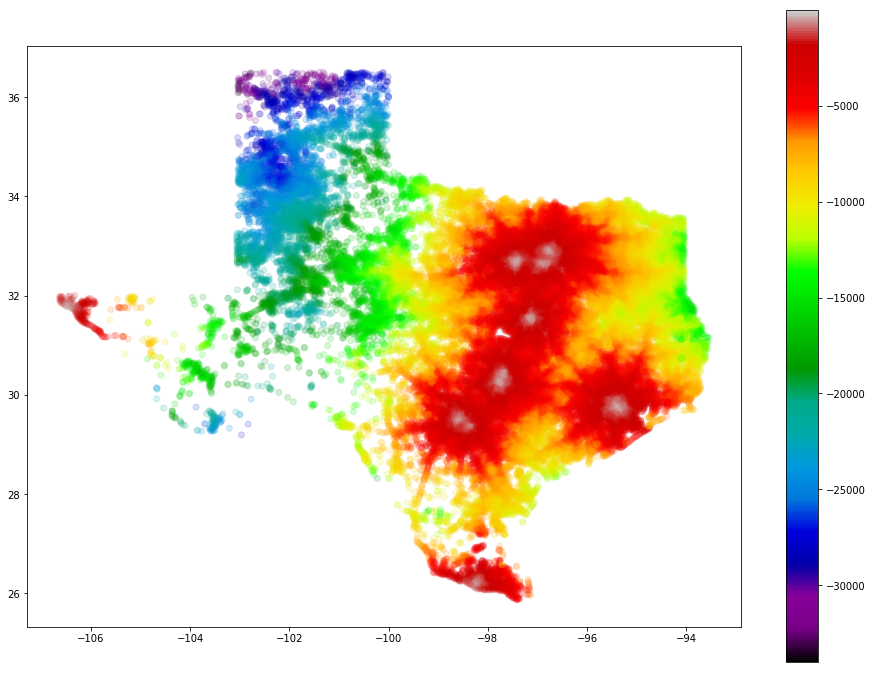

In [9]:
plot_access(gdf, column_name='closest_measurement', log=False)

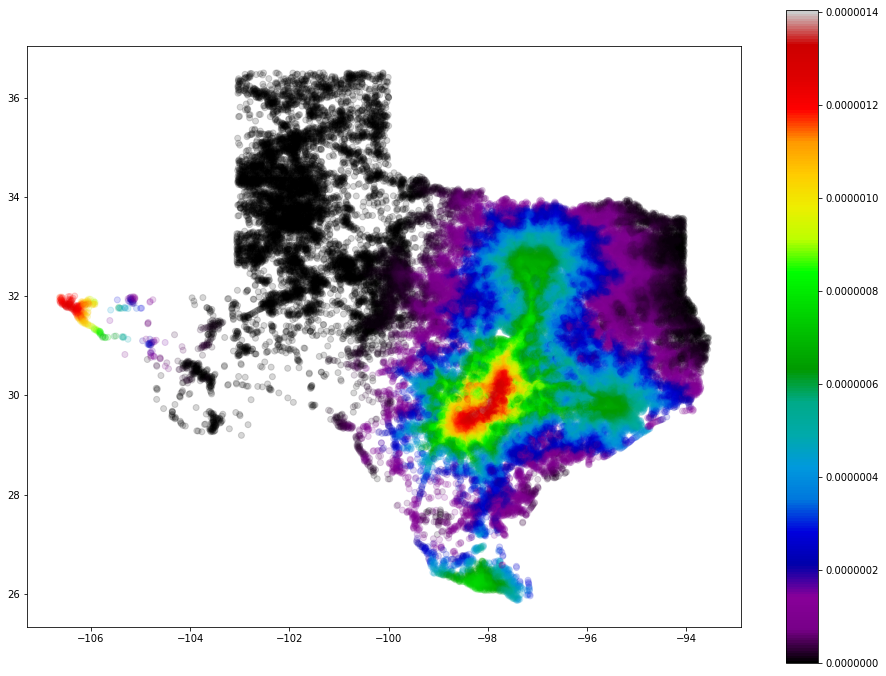

In [10]:
plot_access(gdf)

## Interpretation

Note that the accessibility indexes as measured by the gravity method can be interpreted as provider to population ratios.

We can recover the total supply of a service by computing the average of the accessibility scores weighted by population:

In [11]:
print('There are {} providers.'.format(len(providers_tx_only)))
print('The average of the accessibility scores weighted by population is {}.'.format(
    np.sum(gdf['gravity'].values * gdf['population'].values))
)

There are 17 providers.
The average of the accessibility scores weighted by population is 17.0.


Quoting Wang (2006):

> The accessibility index measured in Equation 5.2 or 5.3 has an important property: the total accessibility scores (sum of accessibility multiplied by demand) are equal to the total supply. This implies that the weighted mean of accessibility is equal to the ratio of total supply to total demand in the study area.

Note that the above maps show the variation in accessibility across the state of Texas but _do not_ provide an assessment of what constitutes good vs. poor geographic access. To know this, we'd have to have a better understanding of what provider-to-population ratios make sensible benchmarks for comparison for the particular service in consideration. 

### TODO
- Plot histograms of accessibility scores (weighted by population)
- Investigate meaningful aggregate scores for the entire region
 - percentiles of the accessibility scores (quartiles? median?)

In [12]:
gdf['gravity'].describe()

count    4.564200e+04
mean     2.985458e-07
std      3.092456e-07
min      4.614305e-19
25%      2.521254e-08
50%      2.040469e-07
75%      4.967266e-07
max      1.403754e-06
Name: gravity, dtype: float64

In [13]:
from statsmodels.stats import weightstats

stats = weightstats.DescrStatsW(gdf['gravity'].values, weights=gdf['population'], ddof=0)

In [14]:
stats.mean*np.sum(gdf['population'])

17.000000000000004

In [15]:
stats.quantile([0.0, 0.10, 0.25, 0.5, 0.75, 0.90])

p
0.00    4.614305e-19
0.10    8.444451e-08
0.25    4.794553e-07
0.50    6.225652e-07
0.75    7.035776e-07
0.90    1.213245e-06
dtype: float64

In [16]:
q1, q2, q3 = stats.quantile([0.10, 0.5, 0.90])
(q3-q1)/(q3+q1)

0.8698540513785493

In [17]:
stats.std / stats.mean

0.569416337704279

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2f03b899b0>]],
      dtype=object)

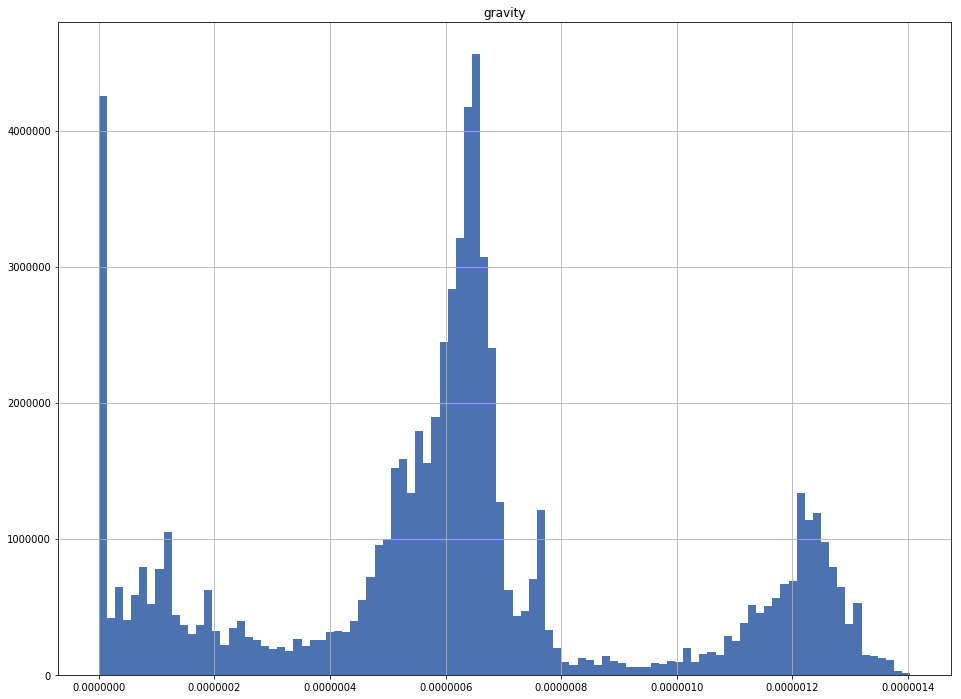

In [18]:
gdf.hist(column='gravity', bins=100, weights=gdf['population'].values, normed=True)

In [19]:
# from statsmodels.nonparametric.kde import KDEUnivariate
# k = KDEUnivariate(gdf['gravity'].values)
# k.fit(weights=gdf['population'].values, fft=False)

In [20]:
def gini(x, w=None):
    # Array indexing requires reset indexes.
    x = pd.Series(x).reset_index(drop=True)
    if w is None:
        w = np.ones_like(x)
    w = pd.Series(w).reset_index(drop=True)
    n = x.size
    wxsum = sum(w * x)
    wsum = sum(w)
    sxw = np.argsort(x)
    sx = x[sxw] * w[sxw]
    sw = w[sxw]
    pxi = np.cumsum(sx) / wxsum
    pci = np.cumsum(sw) / wsum
    g = 0.0
    for i in np.arange(1, n):
        g = g + pxi.iloc[i] * pci.iloc[i - 1] - pci.iloc[i] * pxi.iloc[i - 1]
    return g

In [21]:
gini(gdf['gravity'].values, w=gdf['population'].values)

0.3115834864524436

In [22]:
def weighted_lorenz(x, w=None):
    if w is None:
        w = np.ones_like(x)
    sorted_indexes = np.argsort(x)
    x_ = x[sorted_indexes]
    w_ = w[sorted_indexes]
    n = x.shape[0]    
    cumulative_weighted_x = np.cumsum(x_*w_) / np.sum(x_*w_)
    cumulative_weights = np.cumsum(w_) / np.sum(w_)
    ## scatter plot of Lorenz curve
    fig, ax = plt.subplots()
    ax.scatter(
        x=cumulative_weights, y=cumulative_weighted_x,
        marker='x', color='darkgreen', s=5, alpha=0.04
    )
    ## line plot of equality
    ax.plot([0,1], [0,1], color='k')

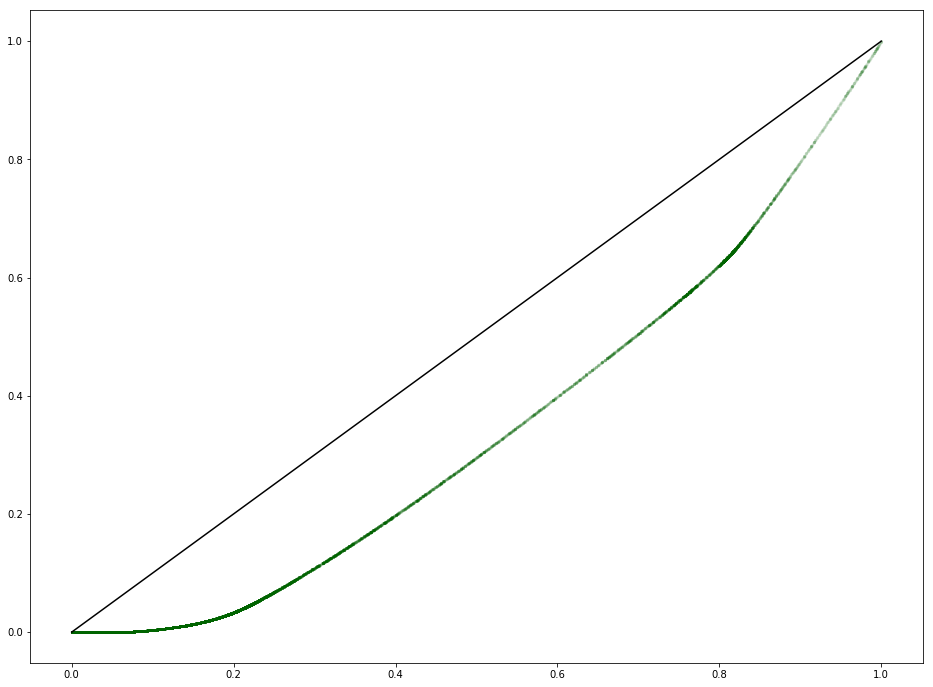

In [23]:
weighted_lorenz(gdf['gravity'].values, w=gdf['population'].values)

Text(0.5,0,'Accessibility Index')

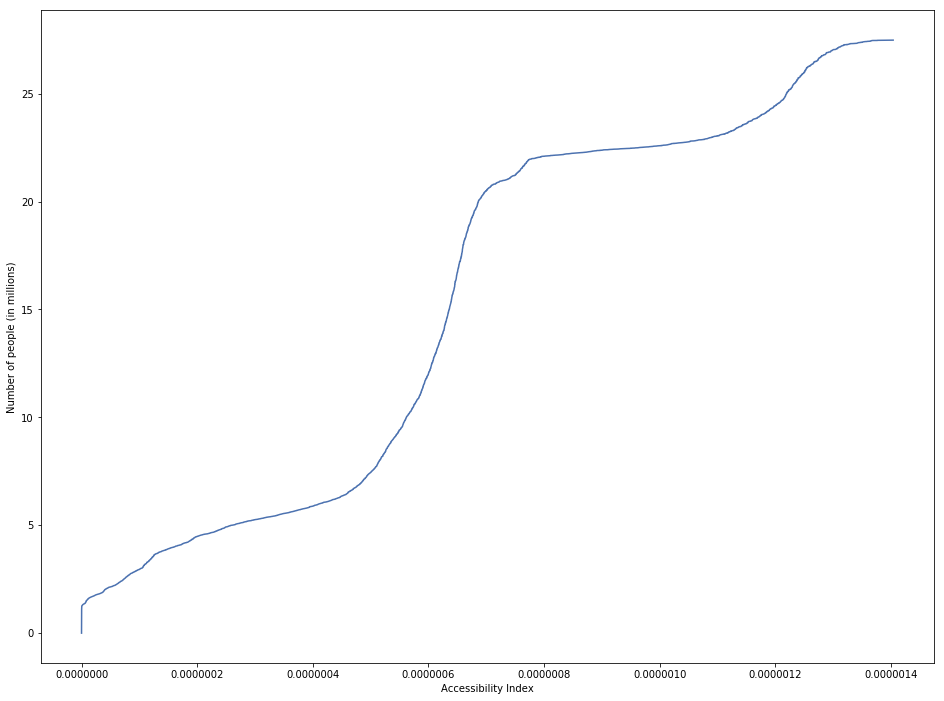

In [24]:
x = gdf['gravity'].values
w = gdf['population'].values
sorted_indexes = np.argsort(x)

x_ = x[sorted_indexes]
w_ = w[sorted_indexes]
cumulative_weights = np.cumsum(w_)

plt.plot(x_, cumulative_weights / 10**6)
plt.ylabel('Number of people (in millions)')
plt.xlabel('Accessibility Index')

In [25]:
gdf.plot?